# 物理概念和过程

用以描述物理概念和过程的 IDS，数据源自物理建模和数值计算程序的结果，例如：

  - 平衡输运：equilibrium, core_profiles, core_transport, core_sources...
  - 物理过程：wave, MHD, turbulence...

对于这类 IDS ，{{FyTok}} 通过Module Plugin机制绑定相对独立的功能模块，然后根据 IMAS Ontology 描述的依赖关系，构建工作流实现集成建模。平衡和芯部输运问题式传统集成建模的主要问题，下图为 1.5 维芯部输运的工作流：

 ![fytok_flow](./figures/FyTok_en.png)

## equilibirum
`equilibirum` 提供二维轴对称托卡马克磁平衡的描述。



### 创建 `equilibrium` 实例

由 `geqdsk` 文件创建`equilibrium` 实例，默认调用插件 `fy_eq`，提供基础的磁面分析计算。

In [1]:
from fytok.modules.Equilibrium import Equilibrium

equilibrium = Equilibrium({"code": {"name": "dummy"}}, "file+geqdsk://./data/g070754.05000#equilibrium")

2023-11-29 21:23:44,558 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.equilibrium.dummy
2023-11-29 21:23:44,562 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_geqdsk


### 可视化

#### 2D 磁面：

给出当前时间片的二维磁场位形（`equilibrium.time_slice.current.profiles_2d.psi`）

2023-11-29 21:23:44,611 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.view.view_matplotlib
2023-11-29 21:23:44,631 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.mesh.mesh_rectilinear


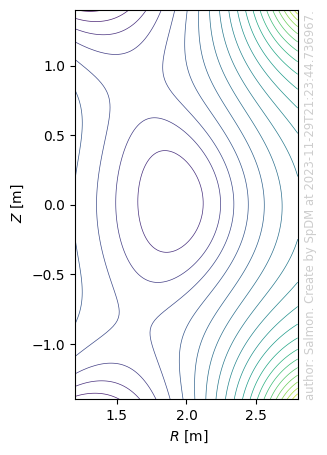

In [2]:
import spdm.view.View as sp_view

fig=sp_view.display(equilibrium.time_slice.current.profiles_2d.psi)

#### 1D 位形分布
绘出当前时间片的一维 profile，磁面坐标为为 $\psi$ `equilibrium.time_slice.current.profiles_1d.psi`

In [3]:
eq_profiles_1d=equilibrium.time_slice.current.profiles_1d

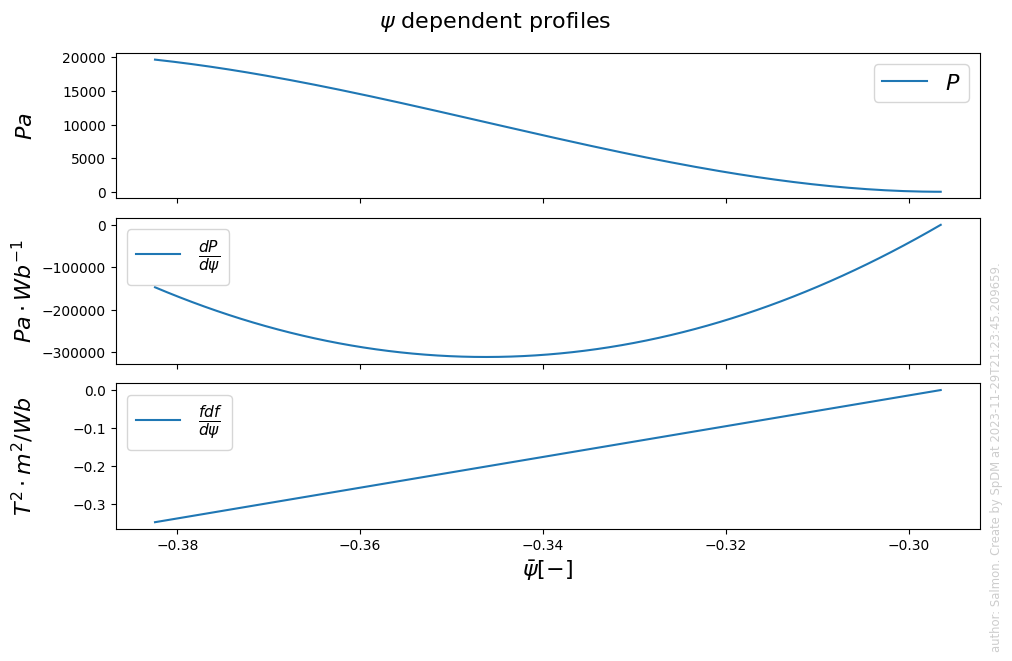

In [4]:
profs = sp_view.plot(
    [
        eq_profiles_1d.pressure,
        eq_profiles_1d.dpressure_dpsi,
        eq_profiles_1d.f_df_dpsi,
    ],
    x_axis=eq_profiles_1d.psi,
    x_label=r"$\bar{\psi}[-]$",
    title=r"$\psi$ dependent profiles",
)

### `class Equilibrium`

除了 $\psi$, $ff^{\prime}$, $p$ 等少数基础信息，其他物理量可通过 `fy_eq` 实时演算获得。

```{eval-rst}

.. autoclass:: fytok.modules.Equilibrium.EquilibriumGlobalQuantities
    :members:
    :show-inheritance: True

.. autoclass:: fytok.modules.Equilibrium.EquilibriumProfiles1D
    :members:
    :undoc-members:
    :show-inheritance: True

.. autoclass:: fytok.modules.Equilibrium.EquilibriumProfiles2D
    :members:
    :undoc-members:
    :show-inheritance: True

.. autoclass:: fytok.modules.Equilibrium.EquilibriumTimeSlice
    :undoc-members: profiles_1d,profiles_2d,global_quantities,vacuum_toroidal_field
    :show-inheritance: True

.. autoclass:: fytok.modules.Equilibrium.Equilibrium
    :members: time_slice
    :member-order: bysource
    :show-inheritance: True

```

## core_profiles
`core_profiles` 芯部分布位形。



``` {note}
`core_profiles.profiles_1d` 以归一化的 $\bar{\rho}$ 为磁面坐标，与 `equilibrium.profiles_1d`采用 $\psi$ 作为磁面坐标不同。

```

### 创建`core_profiles`实例

由专有数据文件，按照预定义的语义读取并转换成 IMAS Ontology。这里`iterprofiles`所代表的`xls`文件中保存了一系列芯部物理量分布。

In [5]:
from fytok.modules.CoreProfiles import CoreProfiles

core_profiles = CoreProfiles(f"file+iterprofiles://./data/15MA Inductive at burn-ASTRA.xls#core_profiles")

2023-11-29 21:23:45,929 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_iterprofiles


### 可视化

绘出一维分布

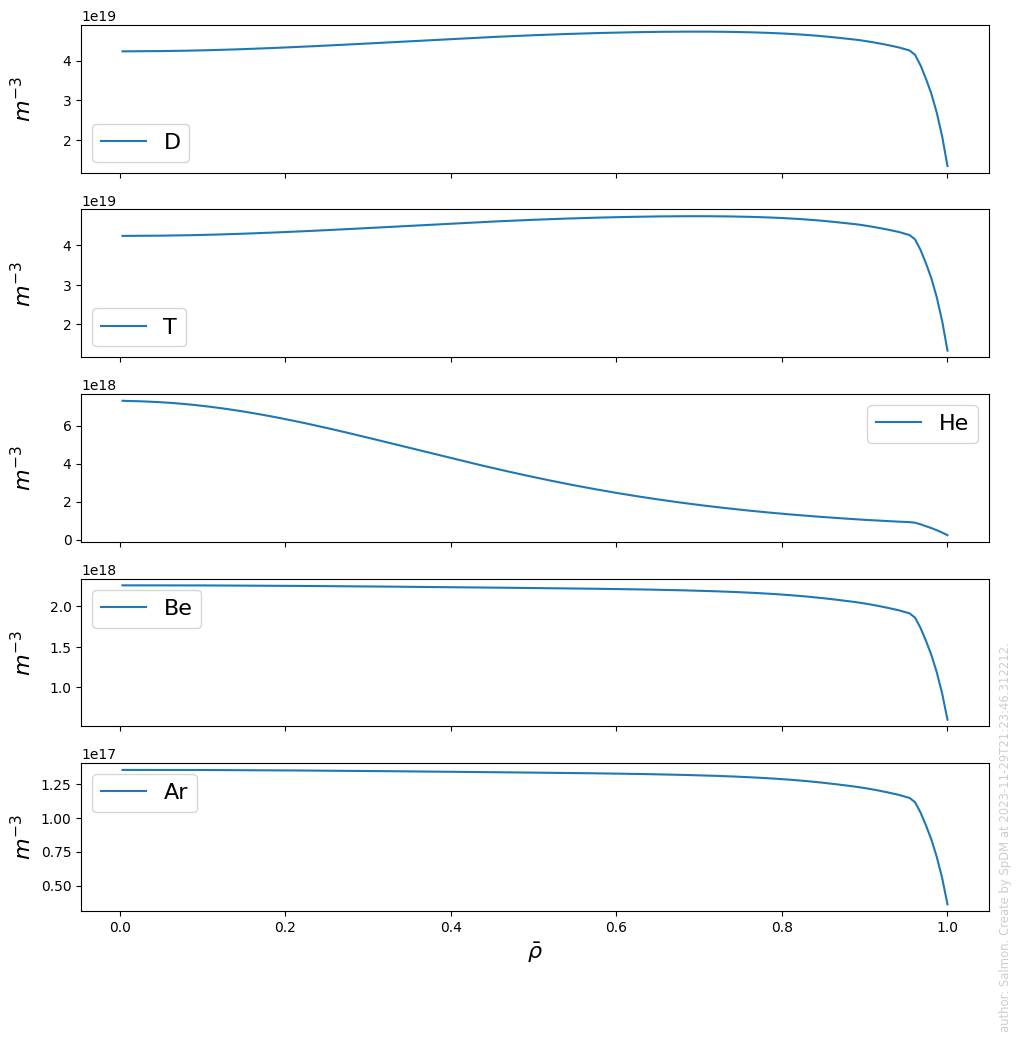

In [6]:
import spdm.view.View as sp_view

fig = sp_view.plot(
    [(ion.density_thermal, ion.label) for ion in core_profiles.time_slice.current.profiles_1d.ion],
    x_value=core_profiles.time_slice.current.profiles_1d.grid.rho_tor_norm,
    x_label=r"$\bar{\rho}$",
    y_label=r"$[m^{-3}]$",
)

### `class CoreProfiles`

```{eval-rst}
 
.. autoclass:: fytok.modules.CoreProfiles.CoreProfiles1D
    :members: 
    :undoc-members:
    :show-inheritance: True

.. autoclass:: fytok.modules.CoreProfiles.CoreProfilesTimeSlice
    :undoc-members: profiles_1d 
    :show-inheritance: True

.. autoclass:: fytok.modules.CoreProfiles.CoreProfiles
    :members: time_slice
    :member-order: bysource
    :show-inheritance: True

```

## core_transport
`core_transport` 芯部输运系数


### 创建 `core_transport`  实例

In [7]:
import numpy as np
from fytok.modules.CoreTransport import CoreTransport
from spdm.data.Expression import Piecewise, Variable

R0 = 1.85
B0 = 1.8

_x = Variable(0, "rho_tor_norm", label=r"\bar{\rho}_{tor}")

x = np.linspace(0, 1, 128)

# Core profiles
r_ped = 0.96  # np.sqrt(0.88)
i_ped = np.argmin(np.abs(x - r_ped))

# Core Transport

Cped = 0.17
Ccore = 0.4
# Function( profiles["Xi"].values,bs_r_norm)  Cped = 0.2
chi = Piecewise([Ccore * (1.0 + 3 * (_x**2)), Cped], [(_x < r_ped), (_x >= r_ped)], label=r"\chi")
chi_e = Piecewise([0.5 * Ccore * (1.0 + 3 * (_x**2)), Cped], [(_x < r_ped), (_x >= r_ped)], label=r"\chi_e")

D = 0.1 * (chi + chi_e)

v_pinch_ne = -0.6 * D * _x / R0
v_pinch_Te = 2.5 * chi_e * _x / R0
v_pinch_ni = D * _x / R0
v_pinch_Ti = chi * _x / R0

time_slice = {
    "profiles_1d": {
        "grid_d": {"rho_tor_norm": x},
        "electrons": {
            "label": "e",
            "particles": {"d": D, "v": v_pinch_ne},
            "energy": {"d": chi_e, "v": v_pinch_Te},
        },
        "ion": [
            {
                "label": "D",
                "particles": {"d": D, "v": v_pinch_ni},
                "energy": {"d": chi, "v": v_pinch_Ti},
            },
            # {
            #     "label": "T",
            #     "particles": {"d": D, "v": v_pinch_ni},
            #     "energy": {"d": chi, "v": v_pinch_Ti},
            # },
            # {
            #     "label": "He",
            #     "particles": {"d": D, "v": v_pinch_ni},
            #     "energy": {"d": chi, "v": v_pinch_Ti},
            # },
        ],
    }
}
core_transport = CoreTransport({"model": [{"code": {"name": "dummy"}, "time_slice": [time_slice]}]})

### 可视化

2023-11-29 21:23:47,208 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.core_transport.model.dummy


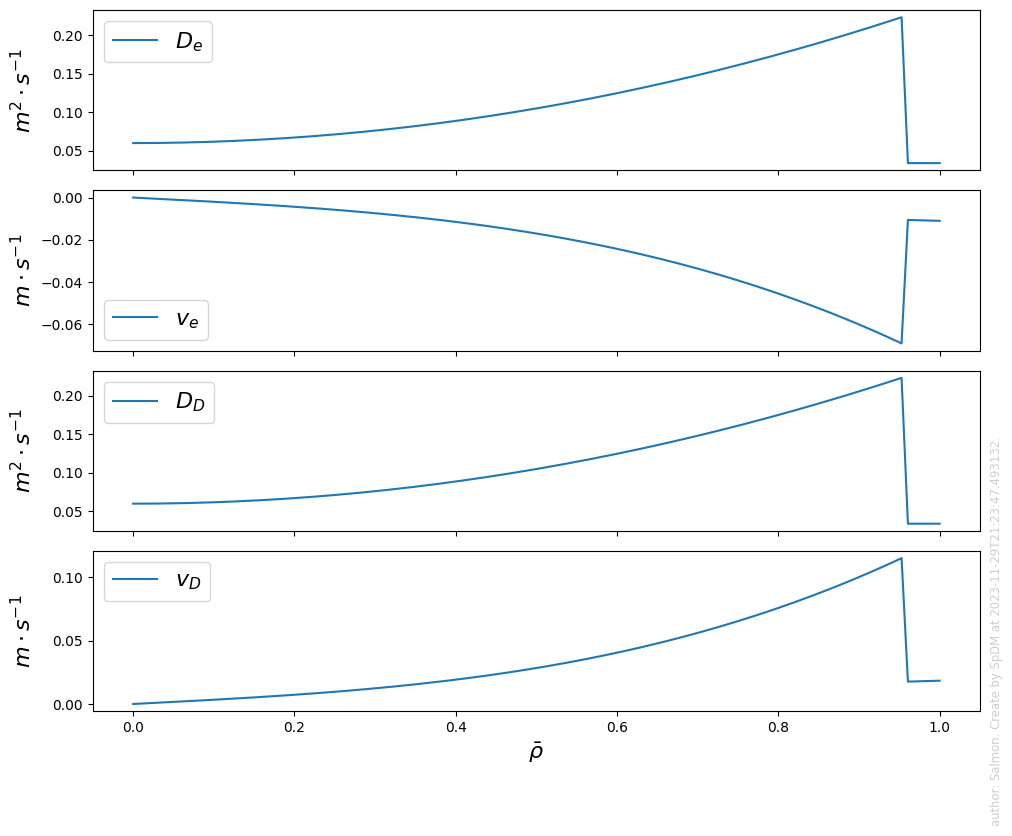

In [8]:
import spdm.view.View as sp_view

core_transport_1d = core_transport.model[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    sum(
        [
            [(ion.particles.d, f"$D_{{{ion.label}}}$"), (ion.particles.v, f"$v_{{{ion.label}}}$")]
            for ion in core_transport_1d.ion
        ],
        [(core_transport_1d.electrons.particles.d, f"$D_e$"), (core_transport_1d.electrons.particles.v, f"$v_e$")],
    ),
    x_value=core_transport_1d.grid_d.rho_tor_norm,
    x_label=r"$\bar{\rho}$",
    y_label=r"$[m^{-3}]$",
)

### `class CoreTransport`


```{eval-rst}

.. autoclass:: fytok.modules.CoreTransport.CoreTransportProfiles1D
    :members:
    :undoc-members:
    :show-inheritance: True

.. autoclass:: fytok.modules.CoreTransport.CoreTransport
    :members: time_slice
    :member-order: bysource
    :show-inheritance: True

```


## core_sources

### `class CoreSources`

```{eval-rst}

.. autoclass:: fytok.modules.CoreSources.CoreSourcesProfiles1D
    :members:
    :undoc-members:
    :show-inheritance: True

.. autoclass:: fytok.modules.CoreSources.CoreSources
    :members: time_slice
    :member-order: bysource
    :show-inheritance: True

```